# Attribute Importance for Concept Drift - Primary and Secondary Drift Detection in one dataset

This notebook allows to detect primary and related secondary driftpoints according to the master thesis' framework.

The user specifies a file path for the dataset to analyze and builds the primary as well as secondary drift detectors.

Outputs are graphs as well as drift point lists.

## Setup
### Imports

In [1]:
# imports
import helper
from pm4py.objects.log.importer.xes import importer as xes_importer

from processdrift.framework import drift_detection
from processdrift.framework import drift_explanation
from processdrift.framework import feature_extraction
from processdrift.framework import population_comparison
from processdrift.framework import windowing
from processdrift.framework import change_point_extraction


import math
import pandas as pd

### Data settings and event log loading

In [2]:
# data settings
data_file_path = 'data/synthetic/attribute_drift/sudden_3_attribute_values/10000/cf10k_0bbd4c9b-97ca-4594-ad55-32d3686e7756.xes' # + 'data\\synthetic\\maardji et al 2013_xes_attributes\\logs\\cb\\cb2.5k.xes' # 

# load event log
event_log = xes_importer.apply(data_file_path)

c:\Users\Lennart\Tools\Anaconda3\envs\concept_drift\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 10000/10000 [00:11<00:00, 864.34it/s]


### Configure Primary Drift Detector

In [3]:
# # # alternative 1: ProDrift Drift detector
# primary_process_drift_detector = drift_detection.ProDriftDD(path_to_prodrift='ProDrift2.5/ProDrift2.5.jar',
#                                                                         drift_detection_mechanism='runs',
#                                                                         window_size=200,
#                                                                         window_mode='adaptive',
#                                                                         detect_gradual_as_well=False)

In [4]:
# alternative 2: Configure custom drift detector
# the user can select 
# - a primary feature extractor, specifying which primary axis feature to use
# - a window generator (fixed size or adaptive) incl. the window sizes and further settings
# - a population comparer
# - a threshold for detecting the change points

primary_window_size = 150
primary_slide_by = 10
primary_feature_extractor = feature_extraction.RelationshipTypesCountFE()
primary_window_generator = windowing.FixedWG(window_size=primary_window_size, slide_by=primary_slide_by)
primary_population_comparer = population_comparison.HotellingsTSquaredPC()

primary_threshold = 0.5
primary_phi = math.ceil(primary_window_size / primary_slide_by / 2)
primary_rho = 1
print(f"primary_phi={primary_phi}, primary_rho={primary_rho}")


primary_change_point_extractor = change_point_extraction.PhiFilterCPE(primary_threshold, primary_phi, primary_rho)

primary_process_drift_detector = drift_detection.WindowTestDD(primary_feature_extractor, 
                                                               primary_window_generator,
                                                               primary_population_comparer, 
                                                               change_point_extractor=primary_change_point_extractor)

primary_phi=8, primary_rho=1


In [5]:
# alternative 3: drift detector true known
# primary_process_drift_detector = drift_detection.TrueKnownDD(helper.get_change_points_maardji_et_al_2013(len(event_log)))

### Configure Secondary Drift Detectors

The user can specify a list of secondary drift detectors.

In [6]:
secondary_window_size = 200
secondary_slide_by = 10
secondary_window_generator = windowing.FixedWG(secondary_window_size, slide_by=secondary_slide_by)
secondary_population_comparer = population_comparison.GTestPC()
secondary_threshold = 0.05
secondary_exclude_attributes = ['concept:name']
secondary_max_distance = 300

secondary_phi = math.ceil(secondary_window_size / secondary_slide_by / 2)
secondary_rho = 1
print(f"secondary_phi={secondary_phi}, secondary_rho={secondary_rho}")

secondary_change_point_extractor = change_point_extraction.PhiFilterCPE(secondary_threshold, secondary_phi, secondary_rho)

secondary_drift_detectors = drift_detection.get_all_attribute_drift_detectors(event_log,
                                                                         secondary_window_generator, 
                                                                         secondary_population_comparer, 
                                                                         exclude_attributes=secondary_exclude_attributes,
                                                                         change_point_extractor=secondary_change_point_extractor)

secondary_phi=10, secondary_rho=1


## Run the Change Point Explainer

In [7]:
# create the change point explainer
drift_explainer = drift_explanation.DriftExplainer(primary_process_drift_detector, secondary_drift_detectors)

# get the change point explanations
possible_drift_explanations = drift_explainer.get_possible_drift_explanations(event_log, max_distance=secondary_max_distance)

c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\explaining_concept_drift\processdrift\framework\drift_detection.py:159: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  change_series = pd.Series(change_dictionary)
c:\Users\Lennart\Documents\1_Workspaces\

In [8]:
# show the possible change point explanations
possible_drift_explanations.possible_drift_explanations

{}

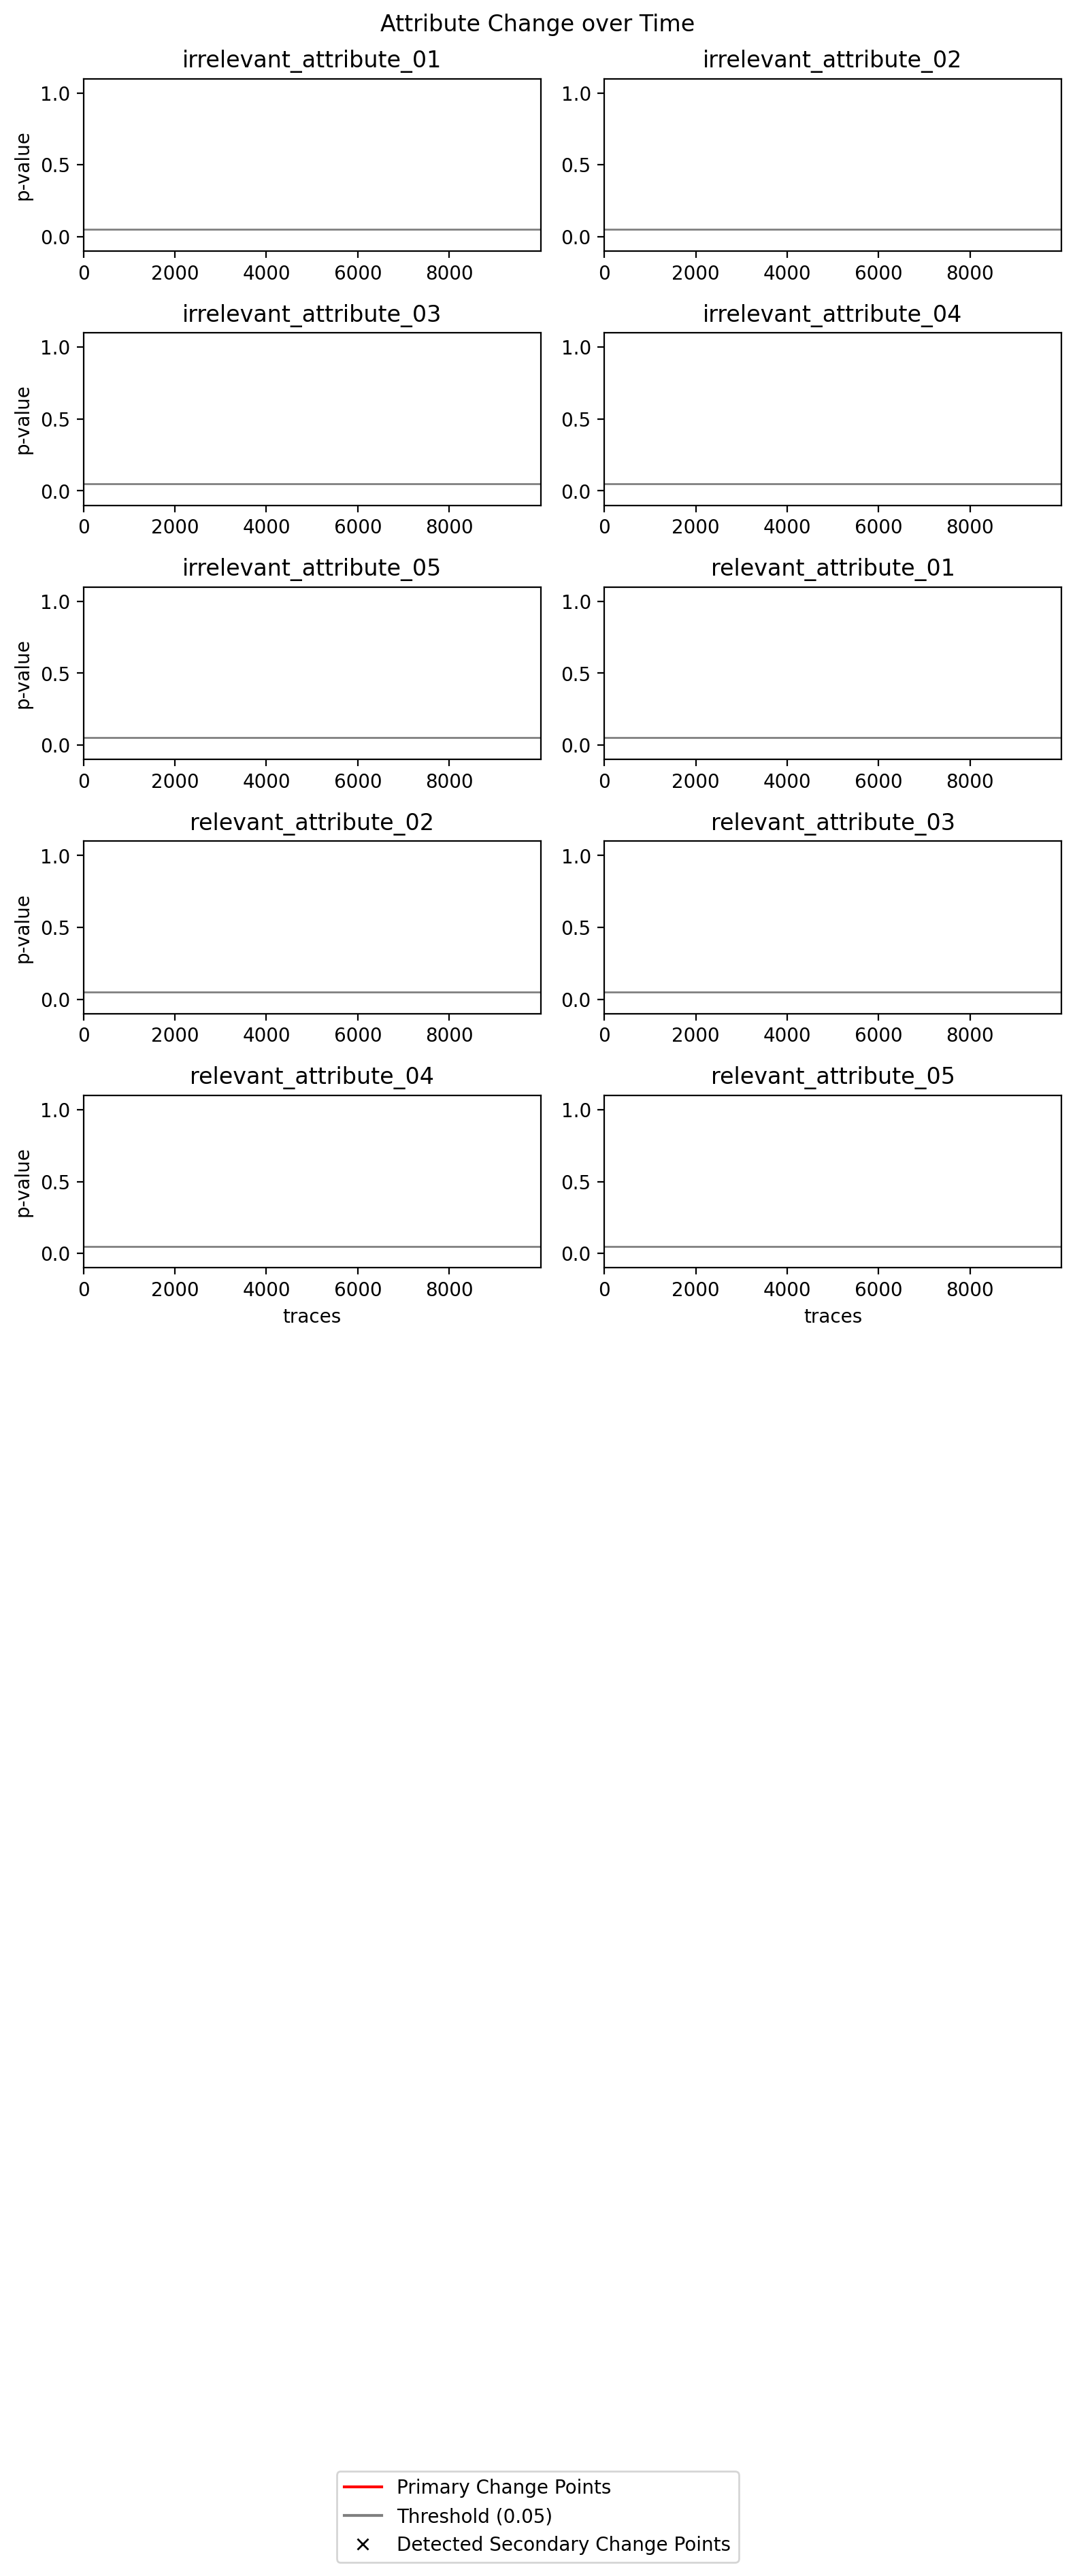

<module 'matplotlib.pyplot' from 'c:\\Users\\Lennart\\Tools\\Anaconda3\\envs\\concept_drift\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [9]:
# plot the drift explanations
possible_drift_explanations.plot(offset_legend=-0.9)

## Perform Runtime Analysis

In [10]:
import cProfile
cProfile.run('drift_explainer.get_possible_drift_explanations(event_log, max_distance=max_distance)', 'profile.stats')

import pstats
p = pstats.Stats("profile.stats")
p.sort_stats(pstats.SortKey.CUMULATIVE)
p.print_stats()

NameError: name 'max_distance' is not defined

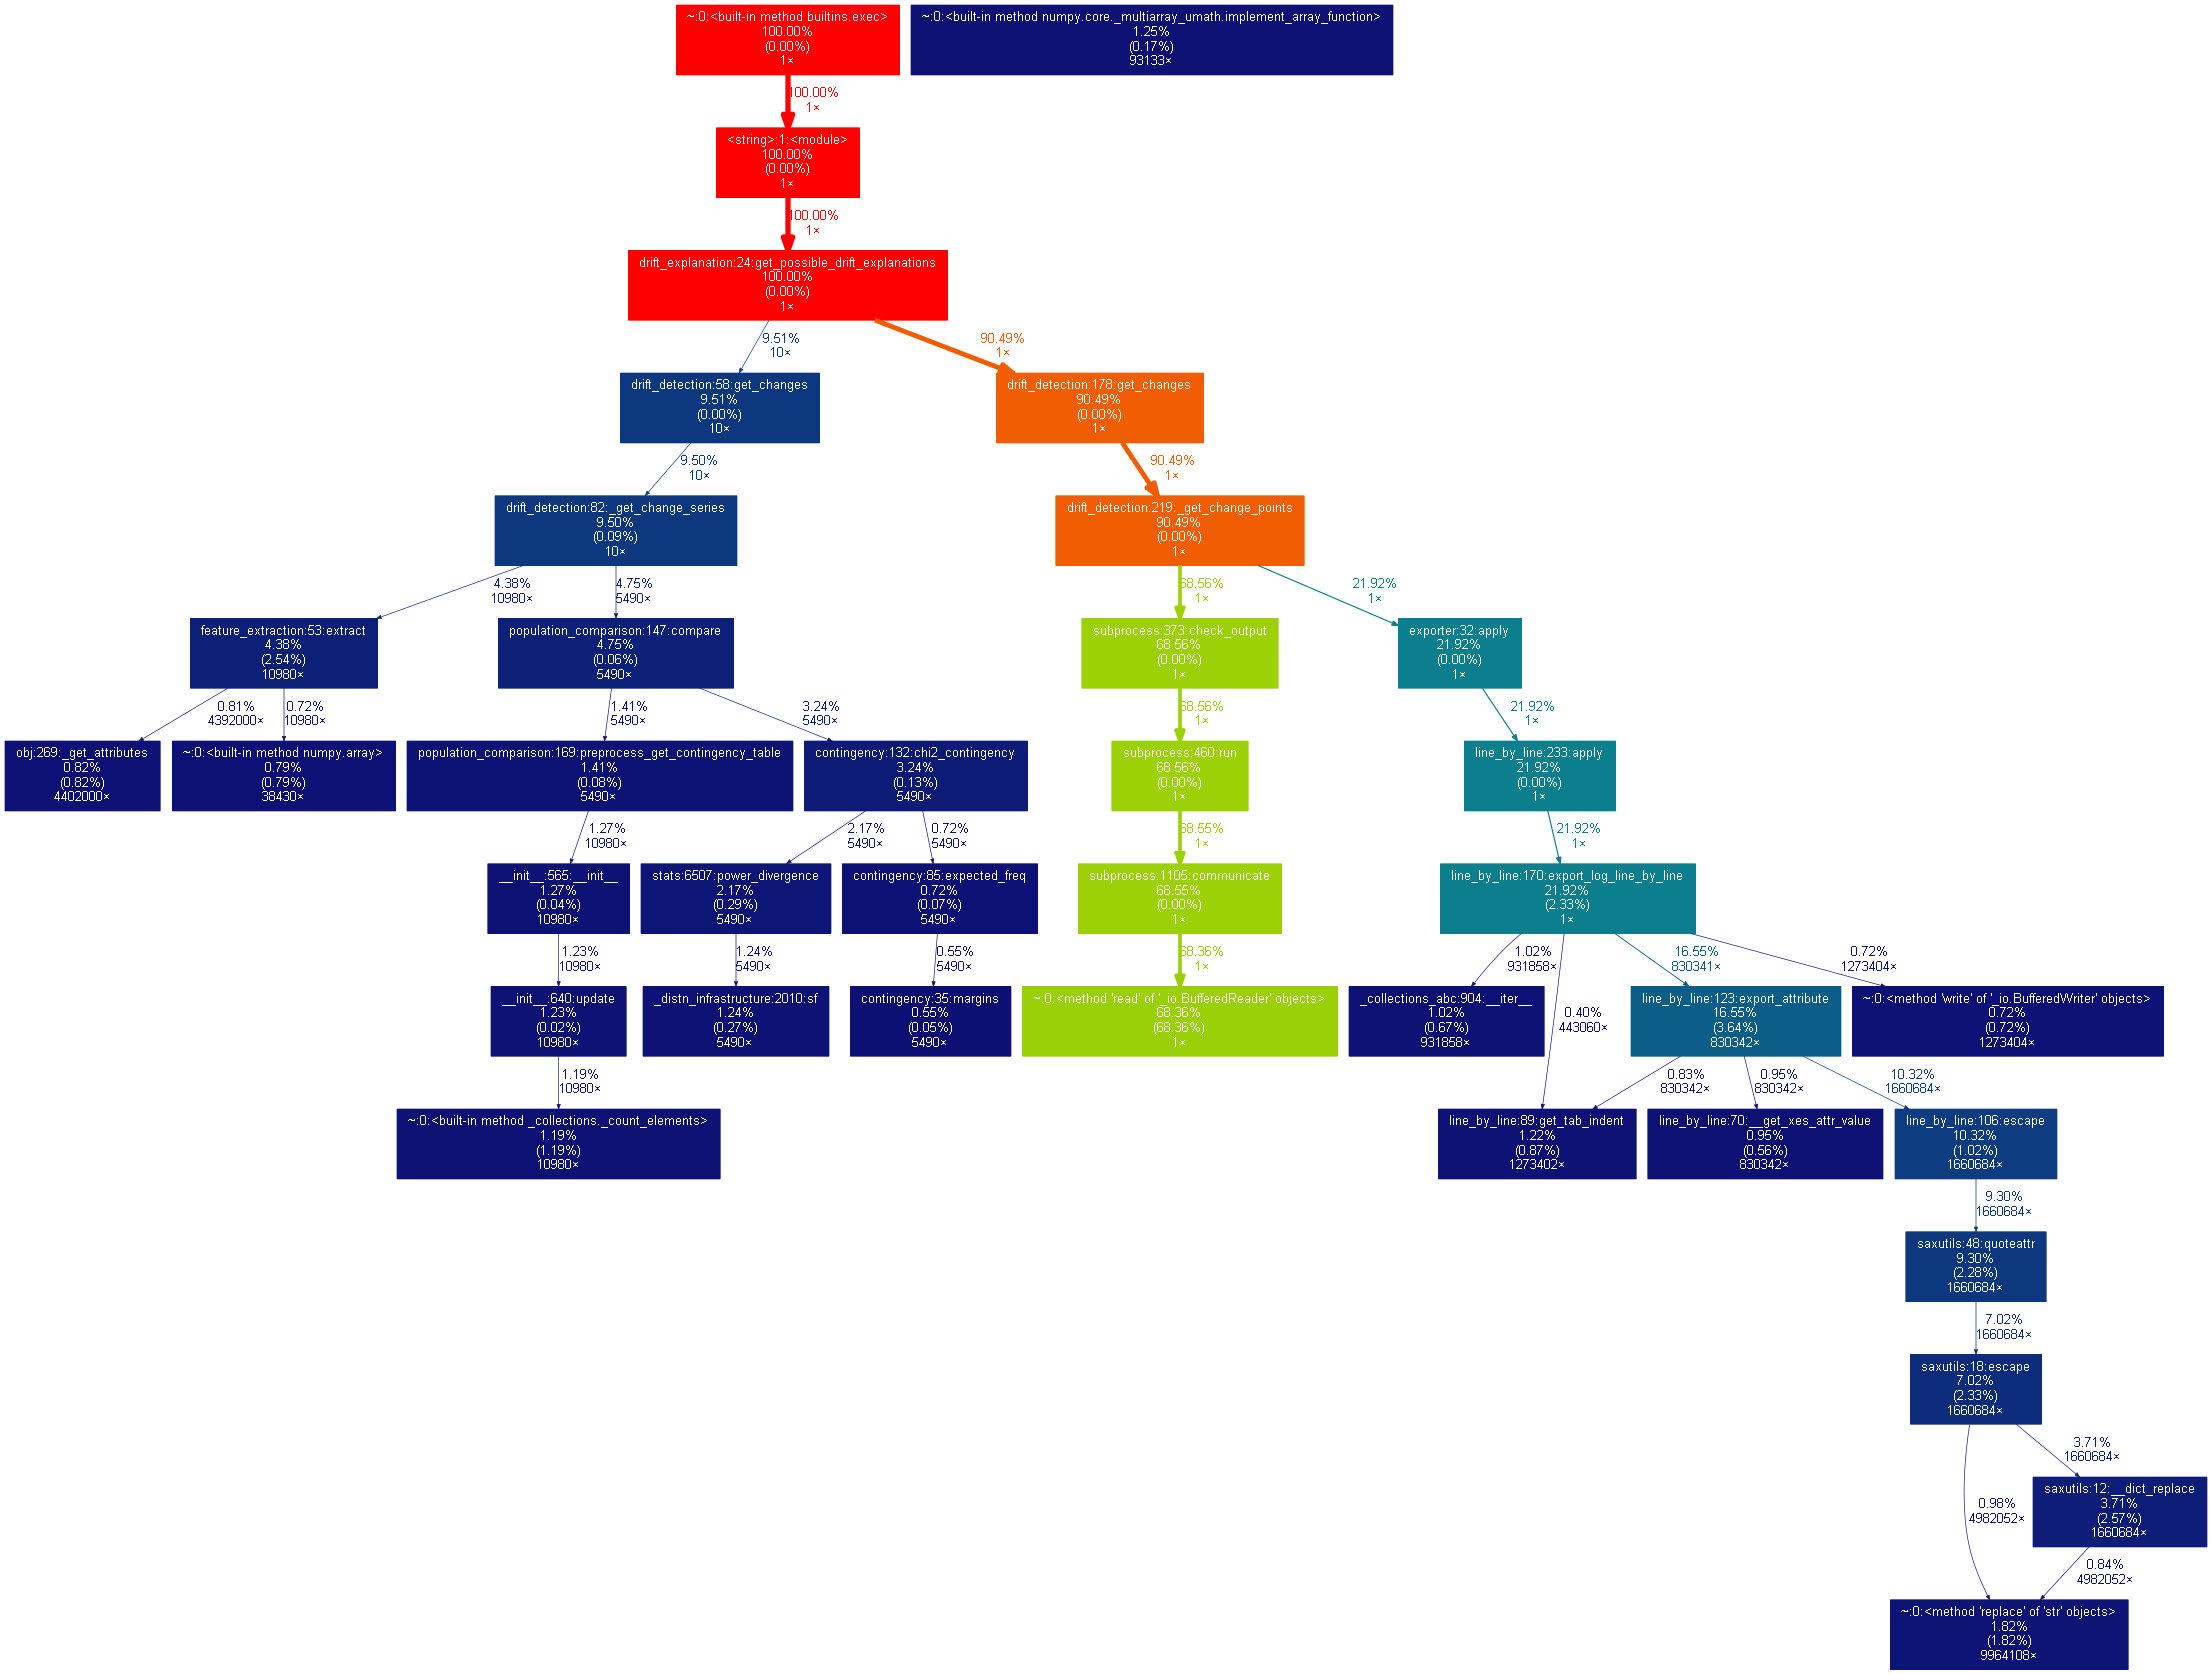

In [ ]:
!gprof2dot profile.stats -f pstats | dot -Tpng -o output.png

from IPython.display import Image
Image(filename='output.png') 